# CNN in Pytroch

本文参考了[Pytroch中的卷积模块](https://wizardforcel.gitbooks.io/learn-dl-with-pytorch-liaoxingyu/4.1.html)。主要记录在Pytorch中使用CNN的基本概念。

## 卷积

卷积在 pytorch 中有两种方式，一种是 torch.nn.Conv2d()，一种是 torch.nn.functional.conv2d()，这两种形式本质都是使用一个**卷积**操作，并且对于**输入**的要求都是一样的，首先需要输入是一个pytorch的tensor，大小是 (batch, channel, H, W)，其中 batch 表示输入的一批数据的数目，第二个是输入的通道数，一般一张彩色的图片是 3，灰度图是 1，而卷积网络过程中的通道数比较大，会出现几十到几百的通道数，H 和 W 表示输入图片的高度和宽度，比如一个 batch 是 32 张图片，每张图片是 3 通道，高和宽分别是 50 和 100，那么输入的大小就是 (32, 3, 50, 100)。

下面举例来说明一下这两种卷积方式。

In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

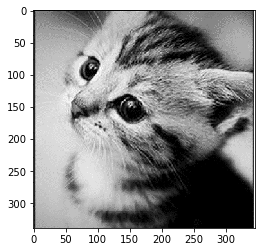

In [5]:
im = Image.open('./cat.png').convert('L') # 读入一张灰度图的图片
im = np.array(im, dtype='float32') # 将其转换为一个矩阵
# 可视化图片
plt.imshow(im.astype('uint8'), cmap='gray')

In [6]:
# 将图片矩阵转化为 pytorch tensor，并适配卷积输入的要求
im = torch.from_numpy(im.reshape((1, 1, im.shape[0], im.shape[1])))
im

tensor([[[[251., 156.,   0.,  ...,   0., 156., 251.],
          [160.,  83.,   0.,  ...,  33., 156., 251.],
          [ 48.,  33.,  16.,  ...,  41., 160., 251.],
          ...,
          [251., 156.,  33.,  ...,  33., 173., 251.],
          [251., 151.,  16.,  ...,  35., 173., 251.],
          [251., 156.,  33.,  ...,  33., 173., 251.]]]])

下面我们定义一个算子对其进行轮廓检测，注意卷积的定义，参考了：[PyTorch快速入门教程四（cnn卷积神经网络）](https://ptorch.com/news/8.html)，还有[Pytorch.nn.conv2d 过程验证（单，多通道卷积过程）](https://zhuanlan.zhihu.com/p/32190799)。卷积层里面常用的参数有四个，in_channels, out_channels, kernel_size, stride, padding.

- in_channels表示的是输入卷积层的图片厚度
- out_channels表示的是要输出的厚度
- kernel_size表示的是卷积核的大小，可以用一个数字表示长宽相等的卷积核，比如kernel_size=3，也可以用不同的数字表示长宽不同的卷积核，比如kernel_size=(3, 2) stride表示卷积核滑动的步长
- padding表示的是在图片周围填充0的多少，padding=0表示不填充，padding=1四周都填充1维

对于单通道卷积核，卷积时，假如32个卷积核，可以学习32种特征，输出就为32个feature map。也就是， 当conv2d( in_channels = 1 , out_channels = N)，有N个filter对输入进行滤波。同时输出N个结果即feature map,每个filter滤波输出一个结果。比如

In [1]:
import torch
##单位矩阵来模拟输入
input=torch.ones(1,1,5,5)
x=torch.nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,groups=1)
out=x(input)
print(out)
print(list(x.parameters()))

tensor([[[[-0.8689, -0.8689, -0.8689],
          [-0.8689, -0.8689, -0.8689],
          [-0.8689, -0.8689, -0.8689]],

         [[-0.1423, -0.1423, -0.1423],
          [-0.1423, -0.1423, -0.1423],
          [-0.1423, -0.1423, -0.1423]],

         [[ 0.9972,  0.9972,  0.9972],
          [ 0.9972,  0.9972,  0.9972],
          [ 0.9972,  0.9972,  0.9972]]]], grad_fn=<ThnnConv2DBackward>)
[Parameter containing:
tensor([[[[-0.0949, -0.0165, -0.2293],
          [-0.2620, -0.2841,  0.3153],
          [-0.1014,  0.0142, -0.1395]]],


        [[[-0.3130, -0.2571, -0.1678],
          [ 0.3146, -0.2146,  0.2780],
          [ 0.1706, -0.0190, -0.0923]]],


        [[[-0.1146,  0.1829,  0.0185],
          [ 0.1871,  0.0983,  0.2550],
          [ 0.2646,  0.2624, -0.0833]]]], requires_grad=True), Parameter containing:
tensor([-0.0707,  0.1583, -0.0737], requires_grad=True)]


输出out的结果和conv2d 的参数如上所示，可以看到，conv2d是有3个filter加一个bias。

对于多通道卷积核卷积，如下图所示，假如在四个通道上的卷积操作，有两个卷积核，生成两个通道。其中需要注意的是，四个通道上每个通道对应一个卷积核，先将w2忽略，只看w1，那么在w1的某位置（i,j）处的值，是由四个通道上（i,j）处的卷积结果相加得到的。 所以最后得到两个feature map， 即输出层的卷积核核个数为 feature map 的个数。

![](v2-286f51de95f0c491c5b6660a0dcd5179_720w.jpg)

In [2]:
##单位矩阵来模拟输入
input=torch.ones(1,3,5,5)
x=torch.nn.Conv2d(in_channels=3,out_channels=4,kernel_size=3,groups=1)
out=x(input)
print(list(x.parameters()))

[Parameter containing:
tensor([[[[-0.1368, -0.0070, -0.0337],
          [ 0.0423, -0.1673,  0.1456],
          [ 0.1660, -0.1632,  0.1441]],

         [[ 0.1546, -0.1450, -0.0748],
          [-0.0208, -0.1880,  0.0277],
          [-0.1827,  0.0251, -0.1841]],

         [[-0.1274, -0.1089, -0.1634],
          [ 0.0909, -0.1870,  0.1051],
          [ 0.1625,  0.1277, -0.1252]]],


        [[[ 0.1406,  0.0619,  0.1433],
          [-0.0166,  0.1284, -0.0057],
          [-0.0271,  0.0339, -0.0665]],

         [[-0.1907, -0.1532,  0.1638],
          [ 0.0540,  0.0193, -0.0512],
          [-0.0583, -0.1056,  0.0257]],

         [[ 0.1853, -0.0390,  0.1520],
          [-0.1027,  0.1005,  0.0069],
          [-0.0016, -0.1910,  0.0061]]],


        [[[ 0.0049, -0.0560, -0.1307],
          [-0.0084, -0.0380, -0.0114],
          [-0.0074, -0.0254,  0.1310]],

         [[ 0.0872,  0.1156, -0.0338],
          [ 0.0187,  0.0512,  0.1719],
          [-0.1138, -0.1863, -0.1019]],

         [[-0.0871,  

可以看到共有4\*3=12个filter 和一个1×4的bias 作用在这个(3,5,5)的单位矩阵上

现在回到本文的图片例子。

In [8]:
# 使用 nn.Conv2d
conv1 = nn.Conv2d(1, 1, 3, bias=False) # 定义卷积

sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # 定义轮廓检测算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出
conv1.weight.data = torch.from_numpy(sobel_kernel) # 给卷积的 kernel 赋值

edge1 = conv1(im) # 作用在图片上
edge1 = edge1.data.squeeze().numpy() # 将输出转换为图片的格式

下面我们可视化边缘检测之后的结果

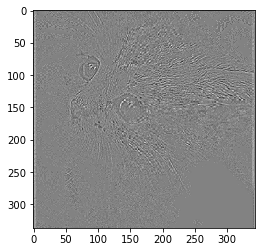

In [9]:
plt.imshow(edge1, cmap='gray')

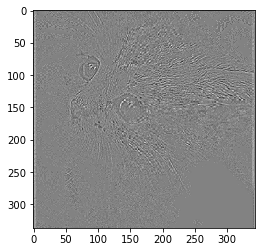

In [11]:
# 使用 F.conv2d
sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # 定义轮廓检测算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出
weight = torch.from_numpy(sobel_kernel)

edge2 = F.conv2d(im, weight) # 作用在图片上
edge2 = edge2.data.squeeze().numpy() # 将输出转换为图片的格式
plt.imshow(edge2, cmap='gray')

可以看到两种形式能够得到相同的效果，不同的地方相信你也看到了，使用 nn.Conv2d() 相当于直接定义了一层卷积网络结构，而使用 torch.nn.functional.conv2d() 相当于定义了一个卷积的操作，所以使用后者需要再**额外去定义一个 weight**，而且这个 weight 也必须是一个 tensor，而使用 nn.Conv2d() 则会帮我们默认定义一个随机初始化的 weight，如果我们需要修改，那么取出其中的值对其修改，如果不想修改，那么可以直接使用这个默认初始化的值，非常方便。

实际使用中我们基本都使用 **nn.Conv2d()** 这种形式.

## 池化层

卷积网络中另外一个非常重要的结构就是池化，这是利用了图片的下**采样不变性**，即一张图片变小了还是能够看出了这张图片的内容，而使用池化层能够将图片大小降低，非常好地提高了计算效率，同时池化层也没有参数。池化的方式有很多种，比如最大值池化，均值池化等等，在卷积网络中一般使用最大值池化。

在 pytorch 中最大值池化的方式也有两种，一种是 nn.MaxPool2d()，一种是 torch.nn.functional.max_pool2d()，他们对于图片的输入要求跟卷积对于图片的输入要求是一样了，就不再赘述，下面也举例说明

In [12]:
# 使用 nn.MaxPool2d
pool1 = nn.MaxPool2d(2, 2)
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im1 = pool1(im)
small_im1 = small_im1.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))

before max pool, image shape: 339 x 345
after max pool, image shape: 169 x 172 


可以看到图片的大小减小了一半，那么图片是不是变了呢？我们可以可视化一下

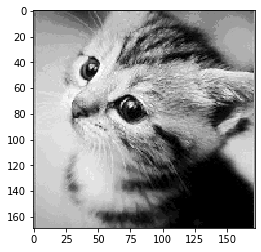

In [13]:
plt.imshow(small_im1, cmap='gray')

可以看到图片几乎没有变化，说明池化层只是减小了图片的尺寸，并**不会影响图片的内容**。

before max pool, image shape: 339 x 345
after max pool, image shape: 169 x 172 


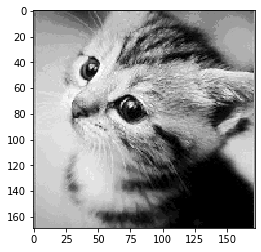

In [14]:
# F.max_pool2d
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im2 = F.max_pool2d(im, 2, 2)
small_im2 = small_im2.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))
plt.imshow(small_im2, cmap='gray')

跟卷积层一样，实际使用中，我们一般使用 **nn.MaxPool2d()**

## 批标准化

**数据预处理和批标准化**十分重要，因为模型训练并不容易，特别是一些非常复杂的模型，并不能非常好的训练得到收敛的结果，所以对数据增加一些预处理，同时使用批标准化能够得到非常好的收敛结果，这也是卷积网络能够训练到非常深的层的一个重要原因。

目前数据预处理最常见的方法就是**中心化和标准化**，中心化相当于修正数据的中心位置，实现方法非常简单，就是在每个特征维度上减去对应的均值，最后得到 0 均值的特征。标准化也非常简单，在数据变成 0 均值之后，为了使得不同的特征维度有着相同的规模，可以除以标准差近似为一个标准正态分布，也可以依据最大值和最小值将其转化为 -1 ~ 1 之间。

在数据预处理的时候，我们尽量输入特征不相关且满足一个标准的正态分布，这样模型的表现一般也较好。但是对于很深的网路结构，网络的非线性层会使得输出的结果变得相关，且不再满足一个标准的 N(0, 1) 的分布，甚至输出的中心已经发生了偏移，这对于模型的训练，特别是深层的模型训练非常的困难。

所以在 2015 年一篇论文提出了**批标准化**，简而言之，就是**对于每一层网络的输出，对其做一个归一化，使其服从标准的正态分布**，这样后一层网络的输入也是一个标准的正态分布，所以能够比较好的进行训练，加快收敛速度。

batch normalization 的实现非常简单，对于给定的一个 batch 的数据 $B = {x_1, x_2, \cdots, x_m}$算法的公式如下
$$ \mu_B = \frac{1}{m} \sum_{i=1}^m x_i$$
$$ \sigma^2_B = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2$$
$$ \hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}$$
$$ y_i = \gamma \hat{x}_i + \beta$$
第一行和第二行是计算出一个 batch 中数据的均值和方差，接着使用第三个公式对 batch 中的每个数据点做标准化，$\epsilon$ 是为了计算稳定引入的一个小的常数，通常取 $10^{-5}$，最后利用权重修正得到最后的输出结果，非常的简单，下面我们可以实现一下简单的一维的情况，也就是神经网络中的情况

In [15]:
import sys
sys.path.append('..')

import torch

def simple_batch_norm_1d(x, gamma, beta):
    eps = 1e-5
    x_mean = torch.mean(x, dim=0, keepdim=True) # 保留维度进行 broadcast
    x_var = torch.mean((x - x_mean) ** 2, dim=0, keepdim=True)
    x_hat = (x - x_mean) / torch.sqrt(x_var + eps)
    return gamma.view_as(x_mean) * x_hat + beta.view_as(x_mean)

In [20]:
x = torch.arange(15).view(5, 3).float()
gamma = torch.ones(x.shape[1])
beta = torch.zeros(x.shape[1])
print('before bn: ')
print(x)
y = simple_batch_norm_1d(x, gamma, beta)
print('after bn: ')
print(y)

before bn: 
tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.],
        [12., 13., 14.]])
after bn: 
tensor([[-1.4142, -1.4142, -1.4142],
        [-0.7071, -0.7071, -0.7071],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.7071,  0.7071,  0.7071],
        [ 1.4142,  1.4142,  1.4142]])


可以看到这里一共是 5 个数据点，三个特征，每一列表示一个特征的不同数据点，使用批标准化之后，每一列都变成了标准的正态分布
这个时候会出现一个问题，就是测试的时候该使用批标准化吗？
答案是肯定的，因为训练的时候使用了，而测试的时候不使用肯定会导致结果出现偏差，但是测试的时候如果只有一个数据集，那么均值不就是这个值，方差为 0 吗？这显然是随机的，所以**测试的时候不能用测试的数据集去算均值和方差，而是用训练的时候算出的移动平均均值和方差去代替**
下面我们实现以下能够区分训练状态和测试状态的批标准化方法

In [21]:
def batch_norm_1d(x, gamma, beta, is_training, moving_mean, moving_var, moving_momentum=0.1):
    eps = 1e-5
    x_mean = torch.mean(x, dim=0, keepdim=True) # 保留维度进行 broadcast
    x_var = torch.mean((x - x_mean) ** 2, dim=0, keepdim=True)
    if is_training:
        x_hat = (x - x_mean) / torch.sqrt(x_var + eps)
        moving_mean[:] = moving_momentum * moving_mean + (1. - moving_momentum) * x_mean
        moving_var[:] = moving_momentum * moving_var + (1. - moving_momentum) * x_var
    else:
        x_hat = (x - moving_mean) / torch.sqrt(moving_var + eps)
    return gamma.view_as(x_mean) * x_hat + beta.view_as(x_mean)

接下来用深度神经网络分类 mnist 数据集的例子来试验一下批标准化是否有用

In [36]:
import numpy as np
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn

In [37]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 数据预处理，标准化
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x
# 使用内置函数下载 mnist 数据集
train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

In [38]:
class multi_network(nn.Module):
    def __init__(self):
        super(multi_network, self).__init__()
        self.layer1 = nn.Linear(784, 100)
        self.relu = nn.ReLU(True)
        self.layer2 = nn.Linear(100, 10)

        self.gamma = nn.Parameter(torch.randn(100))
        self.beta = nn.Parameter(torch.randn(100))

        self.moving_mean = torch.zeros(100)
        self.moving_var = torch.zeros(100)

    def forward(self, x, is_train=True):
        x = self.layer1(x)
        x = batch_norm_1d(x, self.gamma, self.beta, is_train, self.moving_mean, self.moving_var)
        x = self.relu(x)
        x = self.layer2(x)
        return x
    
net = multi_network()
# 定义 loss 函数
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1

In [42]:
from datetime import datetime

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total

def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
    if torch.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            if torch.cuda.is_available():
                im = im.cuda()  # (bs, 3, h, w)
                label = label.cuda()  # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                if torch.cuda.is_available():
                    im = im.cuda()
                    label = label.cuda()
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)
train(net, train_data, test_data, 10, optimizer, criterion)

Epoch 0. Train Loss: 0.292835, Train Acc: 0.917327, Valid Loss: 0.175879, Valid Acc: 0.949070, Time 00:00:07
Epoch 1. Train Loss: 0.165689, Train Acc: 0.951642, Valid Loss: 0.141151, Valid Acc: 0.960146, Time 00:00:08
Epoch 2. Train Loss: 0.130928, Train Acc: 0.961904, Valid Loss: 0.125690, Valid Acc: 0.964794, Time 00:00:07
Epoch 3. Train Loss: 0.110035, Train Acc: 0.967217, Valid Loss: 0.115469, Valid Acc: 0.965091, Time 00:00:07
Epoch 4. Train Loss: 0.094871, Train Acc: 0.972098, Valid Loss: 0.116831, Valid Acc: 0.965585, Time 00:00:07
Epoch 5. Train Loss: 0.084530, Train Acc: 0.974730, Valid Loss: 0.099437, Valid Acc: 0.972310, Time 00:00:07
Epoch 6. Train Loss: 0.075905, Train Acc: 0.977445, Valid Loss: 0.094806, Valid Acc: 0.972310, Time 00:00:08
Epoch 7. Train Loss: 0.067940, Train Acc: 0.979727, Valid Loss: 0.100424, Valid Acc: 0.970233, Time 00:00:07
Epoch 8. Train Loss: 0.062935, Train Acc: 0.980910, Valid Loss: 0.099084, Valid Acc: 0.971915, Time 00:00:07
Epoch 9. Train Loss

这里的 $\gamma$ 和 $\beta$ 都作为参数进行训练，初始化为随机的高斯分布，moving_mean 和 moving_var 都初始化为 0，并不是更新的参数，训练完 10 次之后，我们可以看看移动平均和移动方差被修改为了多少

In [43]:
# 打出 moving_mean 的前 10 项
print(net.moving_mean[:10])

tensor([-0.1093, -1.5858, -0.5348, -5.4668, -1.0652, -0.2670,  1.4671,  1.2183,
         0.0622, -2.3956], grad_fn=<SliceBackward>)


可以看到，这些值已经在训练的过程中进行了修改，在测试过程中，我们不需要再计算均值和方差，直接使用移动平均和移动方差即可.

作为对比，我们看看不使用批标准化的结果

In [44]:
no_bn_net = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(True),
    nn.Linear(100, 10)
)

optimizer = torch.optim.SGD(no_bn_net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1
train(no_bn_net, train_data, test_data, 10, optimizer, criterion)

Epoch 0. Train Loss: 0.407152, Train Acc: 0.873168, Valid Loss: 0.352339, Valid Acc: 0.882812, Time 00:00:06
Epoch 1. Train Loss: 0.188758, Train Acc: 0.942614, Valid Loss: 0.151143, Valid Acc: 0.952927, Time 00:00:08
Epoch 2. Train Loss: 0.143360, Train Acc: 0.956756, Valid Loss: 0.130139, Valid Acc: 0.960542, Time 00:00:08
Epoch 3. Train Loss: 0.115209, Train Acc: 0.965252, Valid Loss: 0.223807, Valid Acc: 0.918612, Time 00:00:08
Epoch 4. Train Loss: 0.099639, Train Acc: 0.969316, Valid Loss: 0.107399, Valid Acc: 0.967069, Time 00:00:08
Epoch 5. Train Loss: 0.087637, Train Acc: 0.972365, Valid Loss: 0.173371, Valid Acc: 0.947686, Time 00:00:08
Epoch 6. Train Loss: 0.078518, Train Acc: 0.975546, Valid Loss: 0.093633, Valid Acc: 0.972409, Time 00:00:08
Epoch 7. Train Loss: 0.070302, Train Acc: 0.978028, Valid Loss: 0.091255, Valid Acc: 0.970728, Time 00:00:08
Epoch 8. Train Loss: 0.063322, Train Acc: 0.979511, Valid Loss: 0.096210, Valid Acc: 0.970036, Time 00:00:07
Epoch 9. Train Loss

可以看到虽然最后的结果两种情况一样，但是如果我们看前几次的情况，可以看到**使用批标准化的情况能够更快的收敛**，因为这只是一个小网络，所以用不用批标准化都能够收敛，但是对于更加深的网络，使用批标准化在训练的时候能够很快地收敛

从上面可以看到，我们自己实现了 2 维情况的批标准化，对应于卷积的 4 维情况的标准化是类似的，只需要沿着通道的维度进行均值和方差的计算，但是我们自己实现批标准化是很累的，pytorch 内置了批标准化的函数，一维和二维分别是 torch.nn.BatchNorm1d() 和 torch.nn.BatchNorm2d()，不同于我们的实现，pytorch 不仅将 $\gamma$ 和 $\beta$ 作为训练的参数，也将 moving_mean 和 moving_var 也作为参数进行训练

下面我们在卷积网络下试用一下批标准化看看效果

In [45]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 数据预处理，标准化
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

# 使用批标准化
class conv_bn_net(nn.Module):
    def __init__(self):
        super(conv_bn_net, self).__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(1, 6, 3, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )

        self.classfy = nn.Linear(400, 10)
    def forward(self, x):
        x = self.stage1(x)
        x = x.view(x.shape[0], -1)
        x = self.classfy(x)
        return x

net = conv_bn_net()
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1

In [46]:
train(net, train_data, test_data, 5, optimizer, criterion)

Epoch 0. Train Loss: 0.147758, Train Acc: 0.957939, Valid Loss: 0.059161, Valid Acc: 0.982595, Time 00:00:24
Epoch 1. Train Loss: 0.056470, Train Acc: 0.982809, Valid Loss: 0.068634, Valid Acc: 0.977551, Time 00:00:26
Epoch 2. Train Loss: 0.043951, Train Acc: 0.986407, Valid Loss: 0.039776, Valid Acc: 0.987540, Time 00:00:26
Epoch 3. Train Loss: 0.036706, Train Acc: 0.988539, Valid Loss: 0.034470, Valid Acc: 0.988430, Time 00:00:26
Epoch 4. Train Loss: 0.032710, Train Acc: 0.990105, Valid Loss: 0.039010, Valid Acc: 0.986748, Time 00:00:27


In [47]:
# 不使用批标准化
class conv_no_bn_net(nn.Module):
    def __init__(self):
        super(conv_no_bn_net, self).__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(1, 6, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )

        self.classfy = nn.Linear(400, 10)
    def forward(self, x):
        x = self.stage1(x)
        x = x.view(x.shape[0], -1)
        x = self.classfy(x)
        return x

net = conv_no_bn_net()
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1

In [48]:
train(net, train_data, test_data, 5, optimizer, criterion)

Epoch 0. Train Loss: 0.211763, Train Acc: 0.932686, Valid Loss: 0.083956, Valid Acc: 0.972903, Time 00:00:20
Epoch 1. Train Loss: 0.074305, Train Acc: 0.976846, Valid Loss: 0.050322, Valid Acc: 0.983485, Time 00:00:22
Epoch 2. Train Loss: 0.057285, Train Acc: 0.981860, Valid Loss: 0.040943, Valid Acc: 0.986056, Time 00:00:22
Epoch 3. Train Loss: 0.048280, Train Acc: 0.984791, Valid Loss: 0.045625, Valid Acc: 0.985759, Time 00:00:21
Epoch 4. Train Loss: 0.042392, Train Acc: 0.986740, Valid Loss: 0.043650, Valid Acc: 0.985957, Time 00:00:21


## fine-tuning

这部分参考：[通过微调进行迁移学习](https://wizardforcel.gitbooks.io/learn-dl-with-pytorch-liaoxingyu/9.1.html)